# [Ezako](https://www.ezako.com) Case-Study
## A data exploratory journey through two e-commerce datasets in order to find anomalous products 
### Presented to you by:
### -Morteza HASHEMI [Github](https://www.github.com/smortezahashemi)
### -Eralda FRROKU

In [7]:
#-------Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#-------Plot size configurarion
plt.rcParams['figure.figsize'] = 15, 5

#-------Load dataset into Pandas Dataframe 
views = pd.read_csv("C:/Users/Spa-Francorchamps/Downloads/eco_v0.2/all_product_2018.csv")
carts = pd.read_csv("C:/Users/Spa-Francorchamps/Downloads/eco_v0.2/all_order_2018.csv")

In [8]:
#-------Convert timestamp to human readable time units
carts.index = pd.to_datetime(carts['timestamp'], unit='ms')
views.index = pd.to_datetime(views['timestamp'], unit='ms')

carts = carts.drop(['timestamp'], axis=1)
views = views.drop(['timestamp'], axis=1)


#-------Small optimization & cleaning
carts.dropna(subset=["product_ids"], inplace=True)
views['product_id'] = views['product_id'].astype('int')

In [5]:
views.head()

,customer_id,product_id,full_price,actual_price
timestamp,,,,
2017-12-31 23:00:21.389,a1768f6141ba9932,1962,238.842975,167.190083
2017-12-31 23:02:09.316,9afedb29c50f8ab9,804,57.024793,57.024793
2017-12-31 23:02:43.368,f5d79ddd326abb30,1681,57.851240,57.851240
2017-12-31 23:03:10.137,64937cc7dc6d57dd,2005,164.462810,115.123967
2017-12-31 23:03:17.932,9c4edff0e7e785e7,2546,681.820579,681.820579


In [6]:
carts.tail()

,customer_id,product_ids,cart_price
timestamp,,,
2018-10-03 09:46:44.771,fa52201d38369060,527|696|825,27.05
2018-10-03 10:41:43.425,6c424d74c52a6601,47,18.40
2018-10-03 10:45:54.570,7e48090cbb1eba3a,1669|1472|3806|94,159.84
2018-10-03 11:03:55.150,7e48090cbb1eba3a,1669|1472|3806|94,159.84
2018-10-03 11:28:07.719,3b34464611a1aa02,47,18.40


In [4]:
#------Spliting 'product_ids' column in carts dataframe by delimiter "|"

lst = []
index = []

for row in carts.iterrows():
    vals = row[1].values
    product_ids = vals[1]
    for id_prod in product_ids.split("|"):
        lst.append([vals[0], int(id_prod), vals[2]])
        index.append(row[0])


cols = carts.columns.tolist()
cart_flatten = pd.DataFrame(lst, columns=cols, index=index)
cart_flatten.head()

,customer_id,product_ids,cart_price
2017-12-31 23:41:11.712,401a01d8c3a64e11,188,28.89
2017-12-31 23:41:11.712,401a01d8c3a64e11,1439,28.89
2018-01-01 11:56:16.242,3e87edf753a9f1a1,2790,199.95
2018-01-01 13:26:38.703,bd750602eac31a94,157,11.20
2018-01-01 13:40:24.978,3e083e3a130b21b2,647,17.85


In [9]:
#-----------Merge the two datasets (cart_flatten and views)
mergedProd = cart_flatten.merge(views, how='left', left_on='product_ids', 
                                right_on='product_id', suffixes=['_cart', '_view'])


#-----------Locating rows where the "product_id" is null
mergedProd[mergedProd['product_id'].isnull()]


#----------Drop Na rows
mergedProd.dropna(subset=['product_id'], inplace=True)

mergedProd.head()

,customer_id_cart,product_ids,cart_price,customer_id_view,product_id,full_price,actual_price
0,401a01d8c3a64e11,188,28.89,7b4464d06d7ffbfb,188.0,4.950413,4.950413
1,401a01d8c3a64e11,188,28.89,75dd9fe3daae2927,188.0,4.950413,4.950413
2,401a01d8c3a64e11,188,28.89,ba557ca06e436eaf,188.0,4.950413,4.950413
3,401a01d8c3a64e11,188,28.89,485fbe5297fbeefa,188.0,4.950413,4.950413
4,401a01d8c3a64e11,188,28.89,c0e3a1443cb5d177,188.0,4.950413,4.950413


In [9]:
groupedView = views.groupby('product_id')
groupedCart = cart_flatten.groupby('product_ids')
numOfViewsPerProd = groupedView.count()['customer_id']
numOfPurchasesPerProd = groupedCart.count()['customer_id']

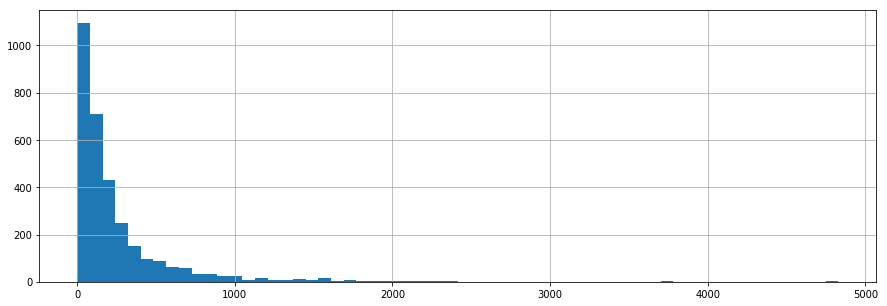

In [42]:
numOfViewsPerProd.hist(bins=60)

#### Statistics on _views_ and _carts_ dataframes:
- __views__: Numbers indicate the frequency of views per each product
- __carts__: Numbers indicate the frequency of purchases (being added to cart) per each product

In [25]:
print(numOfViewsPerProd.describe(),'\n')
print("Median ",format(numOfViewsPerProd.median()))

count    3181.000000
mean      260.152468
std       403.532928
min         1.000000
25%        57.000000
50%       132.000000
75%       289.000000
max      4828.000000
Name: customer_id, dtype: float64 

Median  132.0


In [36]:
print(numOfPurchasesPerProd.describe(),'\n')
print("Median ",format(numOfPurchasesPerProd.median()))


count    1910.000000
mean        5.060733
std        11.945023
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       165.000000
Name: customer_id, dtype: float64 

Median  2.0


- median of 2 indicates that on the second quartile items have been purchased only two times!

- products with minimal number of views:

In [14]:
numOfViewsPerProd[numOfViewsPerProd<20].count()

320

In [15]:
#-----Picking products that have been viewed at least 20 times over the period
indRemove = numOfViewsPerProd[numOfViewsPerProd<20].index
modifiedViews = numOfViewsPerProd[~numOfViewsPerProd.index.isin(indRemove)]
modifiedPurchases = numOfPurchasesPerProd[~numOfPurchasesPerProd.index.isin(indRemove)]

df = pd.DataFrame({'view': modifiedViews, 'purchase': modifiedPurchases})
df.head()

,view,purchase
2,3762.0,126.0
3,3960.0,6.0
14,1164.0,11.0
15,156.0,2.0
17,100.0,NaN


In [16]:
purchasePerView = (df['purchase'] / df['view'])
viewPerPurchase = (df['view'] / df['purchase'])
purchasePerView.head()

2     0.033493
3     0.001515
14    0.009450
15    0.012821
17         NaN
dtype: float64

In [17]:
print("Best Seller Ratio: {}".format(purchasePerView.max()))
print("Least Seller Ratio: {}".format(viewPerPurchase.max()))

Best Seller Ratio: 0.5
Least Seller Ratio: 3571.0


- Plotting _purchase per view_ and _view per purchase_ reveals more information on best-selling and least-selling products. Additioanlly, it helps to spot record high ratios.

Text(0, 0.5, 'Purchase per view ratio')

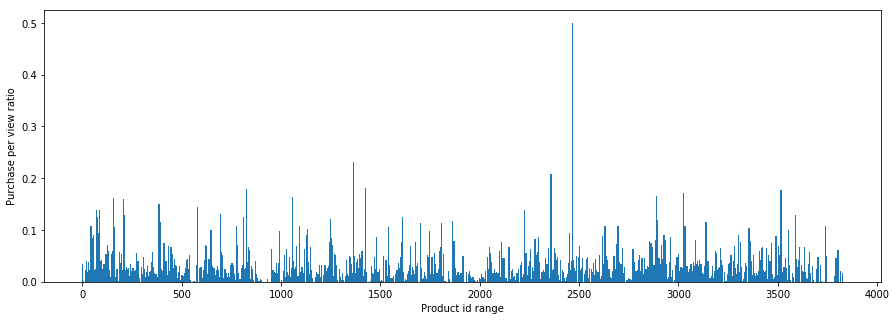

In [19]:
plt.bar(purchasePerView.index, purchasePerView, width=6)
plt.xlabel("Product id range")
plt.ylabel("Purchase per view ratio")

Text(0, 0.5, 'View per purchase ratio')

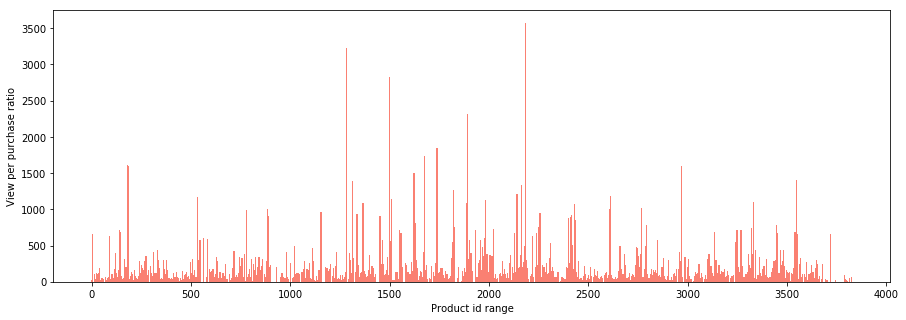

In [20]:
plt.bar(viewPerPurchase.index, viewPerPurchase, width=6, color='salmon')
plt.xlabel("Product id range")
plt.ylabel("View per purchase ratio")

In [21]:
print("Top 5 purchase/view ratios:")
print(purchasePerView.nlargest(5),'\n\n')
print("Top 5 view/purchase ratios:")
print(viewPerPurchase.nlargest(5))

Top 5 purchase/view ratios:
2469    0.500000
1364    0.230769
2359    0.208333
1425    0.181818
825     0.179348
dtype: float64 


Top 5 view/purchase ratios:
2184    3571.0
1282    3225.0
1501    2820.0
1893    2313.0
1738    1849.0
dtype: float64


#### We are interested in behavior of "least-selling" products :
- Product id: 2184 with the ratio of 3571 views per each purchase over the whole period. 

In [71]:
views[views['product_id'] == 2184]

,customer_id,product_id,full_price,actual_price
timestamp,,,,
2018-01-01 00:23:49.626,a02b997bf5257800,2184,321.487603,321.487603
2018-01-01 00:37:32.533,a02b997bf5257800,2184,321.487603,321.487603
2018-01-01 13:10:54.466,bc5ba20b1f3183f1,2184,321.487603,321.487603
2018-01-01 13:11:38.016,bc5ba20b1f3183f1,2184,321.487603,321.487603
2018-01-01 15:07:16.085,081c3a51286a088a,2184,321.487603,321.487603
2018-01-01 15:11:21.695,081c3a51286a088a,2184,321.487603,321.487603
2018-01-01 15:20:08.555,081c3a51286a088a,2184,321.487603,321.487603
2018-01-01 15:29:28.301,081c3a51286a088a,2184,321.487603,321.487603
2018-01-01 15:56:59.582,081c3a51286a088a,2184,321.487603,321.487603


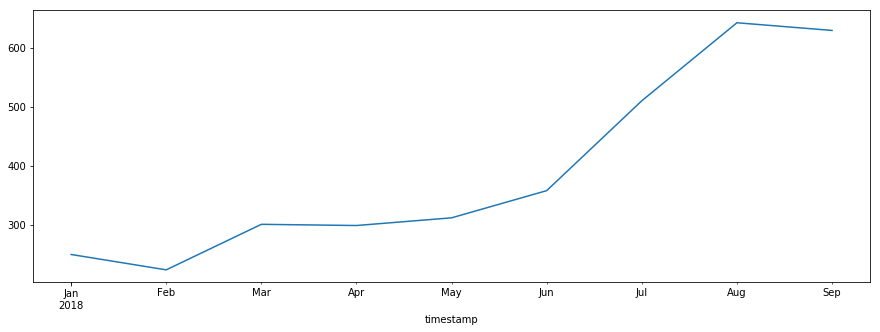

In [72]:
noSellView = views[views['product_id'] == 2184]['Jan 2018':'Sep 2018']
noSellView = noSellView.resample('M').count()['customer_id']
noSellView.plot()

In [75]:
cart_flatten[cart_flatten['product_ids'] == 2184]

,customer_id,product_ids,cart_price
2018-05-19 10:17:20.553,9d6b6abc55e4cf47,2184,4158.1


#### We are also interested in behavior of "Best-sellers" (are they really?)
- product id: 2469 has the purchase/view ratio of 0.5 -> It means 50% chance of purchase for every view

In [86]:
cart_flatten[cart_flatten['product_ids'] == 2469]

,customer_id,product_ids,cart_price
2018-01-31 15:48:26.388,6e7792695c700721,2469,42.88
2018-01-31 15:51:41.150,6e7792695c700721,2469,42.88
2018-01-31 15:51:43.618,6e7792695c700721,2469,42.88
2018-01-31 15:53:06.415,6e7792695c700721,2469,42.88
2018-01-31 15:53:31.383,6e7792695c700721,2469,42.88
2018-01-31 15:53:33.415,6e7792695c700721,2469,42.88
2018-01-31 15:54:00.051,6e7792695c700721,2469,42.88
2018-01-31 15:54:40.887,6e7792695c700721,2469,42.88
2018-01-31 15:54:43.218,6e7792695c700721,2469,42.88
2018-01-31 15:55:56.298,6e7792695c700721,2469,42.88


Evidently there was a guy who repeatedly add the item to the cart, yet we do not know if he finally bought it or not. 

#### We are also interested in behavior of "Best sellers" (are they really?)
- product id: 2469 has the purchase/view ratio of 0.5 -> It means 50% chance of purchase for every view
- product id: 825 has the purchase/view ratio of 0.179348

In [98]:
bestSellerView = views[views['product_id'] == 825]
bestSellerView = bestSellerView['Jan 2018' : 'Sep 2018']
bestSellerCart = cart_flatten[cart_flatten['product_ids'] == 825]
bestSellerCart = bestSellerCart['Jan 2018' : 'Sep 2018']
bestSellerCart.head()

,customer_id,product_ids,cart_price
2018-01-04 16:50:39.608,80df2f97917306bb,825,42.00
2018-01-19 17:27:35.528,ff56e18147723fa4,825,879.84
2018-02-05 22:20:38.771,0030800434897a86,825,30.90
2018-02-23 17:19:49.206,548d7b3e16143c18,825,1391.92
2018-03-20 15:28:46.281,4cc26592cce2de11,825,38.20


In [99]:
bestSellerCartByWeek = bestSellerCart.resample('M').count()['customer_id']
bestSellerViewByWeek = bestSellerView.resample('M').count()['customer_id']

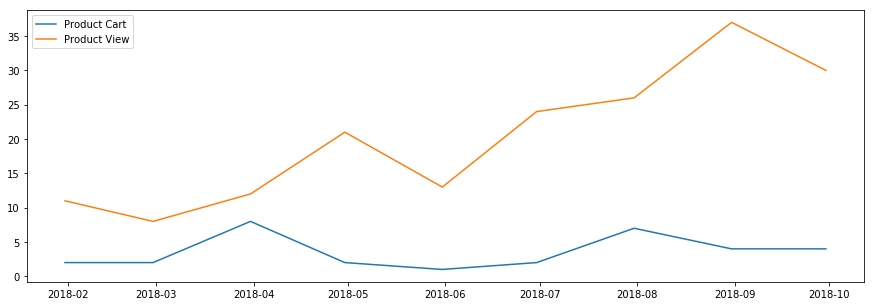

In [100]:
plt.plot(bestSellerCartByWeek.index, bestSellerCartByWeek, label='Product Cart')
plt.plot(bestSellerViewByWeek.index, bestSellerViewByWeek, label='Product View')
plt.legend(loc='upper left')

#### Products with the most number of purchases:

In [101]:
df['purchase'].nlargest()

44      165.0
47      154.0
1129    154.0
46      153.0
53      145.0
Name: purchase, dtype: float64

In [102]:
cartID44 = cart_flatten[cart_flatten['product_ids'] == 44]['Jan 2018' : 'Sep 2018']
viewID44 = views[views['product_id'] == 44]['Jan 2018' : 'Sep 2018']
cartID44ByDay = cartID44.resample('M').count()['customer_id']
viewID44ByDay = viewID44.resample('M').count()['customer_id']

Text(0.5,1,'Product id: 44')

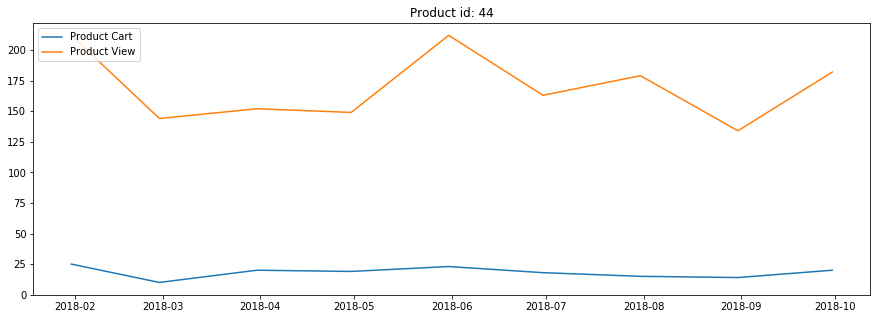

In [103]:
plt.plot(cartID44ByDay.index, cartID44ByDay, label='Product Cart')
plt.plot(viewID44ByDay.index, viewID44ByDay, label='Product View')
plt.legend(loc='upper left')
plt.title("Product id: 44")

In [104]:
cartID_1129 = cart_flatten[cart_flatten['product_ids'] == 1129]['Jan 2018' : 'Sep 2018']
viewID_1129 = views[views['product_id'] == 1129]['Jan 2018' : 'Sep 2018']
cartID_1129_ByDay = cartID_1129.resample('M').count()['customer_id']
viewID_1129_ByDay = viewID_1129.resample('M').count()['customer_id']

Text(0.5,1,'Product id: 1129')

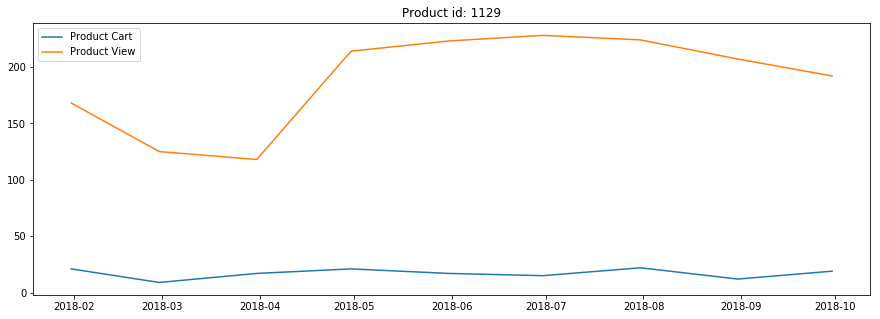

In [105]:
plt.plot(cartID_1129_ByDay.index, cartID_1129_ByDay, label='Product Cart')
plt.plot(viewID_1129_ByDay.index, viewID_1129_ByDay, label='Product View')
plt.legend(loc='upper left')
plt.title("Product id: 1129")

#### Anomaly in products sell:
- Sheer number of views with few number of purchase
- Contradictory behavior in product view and purchase

##### Contradictory behavior:
- Products existing for more than 5 months in the dataframe
- Items being put to the cart at least 10 times
- Compute correlation (Pearson) between purchases and views for each product $$ r = \frac{\sum\limits_{i=1}^{n} {(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum\limits_{i=1}^{n} {(x_i - \bar{x})^2}}\sqrt{\sum\limits_{i=1}^{n} {(y_i - \bar{y})^2}}}$$

In [3]:
def timeDelta(pid):
    lastEntry = len(views[views['product_id'] == pid]) - 1
    res = (views[views['product_id'] == pid].index[lastEntry] - views[views['product_id'] == pid].index[0] 
           >
           pd.Timedelta(days=150))
    return res

In [12]:
ind = []
for row in views['product_id'].unique():
    if timeDelta(row):
        ind.append(row)
        
viewCounts = (views[views['product_id'].isin(ind)]['Jan 2018':'Sep 2018']
              .groupby('product_id')
              .resample('M')
              .count()['customer_id'])

numOfPurchasesPerProd = groupedCart.count()['customer_id']
purchaseIndex = numOfPurchasesPerProd[numOfPurchasesPerProd > 10].index
purchaseCount = (cart_flatten[cart_flatten['product_ids'].isin(purchaseIndex)]['Jan 2018':'Sep 2018']
                 .groupby('product_ids')
                 .resample('M')
                 .count()['customer_id'])

In [20]:
monthlyStat = pd.concat([purchaseCount, viewCounts], axis=1, join='inner', keys=['purchase', 'view'])
monthlyStat.head()

purchase  view
2 2018-01-31        16   463
  2018-02-28        13   438
  2018-03-31        15   320
  2018-04-30        12   381
  2018-05-31         9   328

In [21]:
monthlyStat.reset_index(level=1,drop=True, inplace=True)

In [22]:
prodCorr = monthlyStat.groupby(monthlyStat.index).corr().iloc[0::2][['view']]
prodCorr.head()

,,view
2,purchase,-0.110291
14,purchase,0.053417
23,purchase,-0.212022
43,purchase,-0.113892
44,purchase,0.752232


In [23]:
prodCorr['view'].nsmallest(5)

3357  purchase   -0.413712
208   purchase   -0.411018
211   purchase   -0.395179
151   purchase   -0.374792
2777  purchase   -0.364257
Name: view, dtype: float64

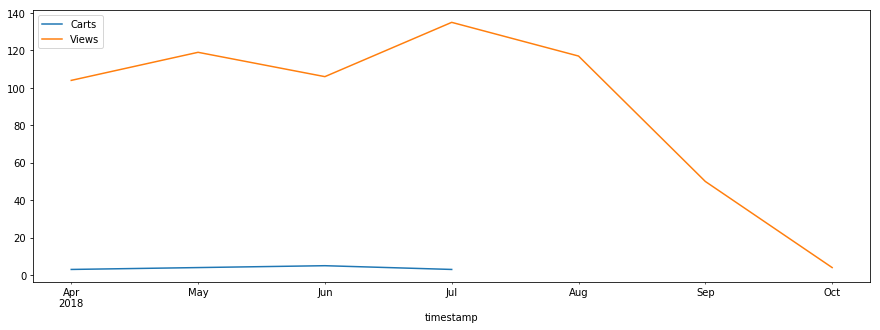

In [34]:
a = cart_flatten[cart_flatten['product_ids'] == 3357].resample('M')['customer_id'].count()
b = views[views['product_id'] == 3357].resample('M')['customer_id'].count()
a.plot(label='Carts')
b.plot(label='Views')
plt.legend(loc='upper left')

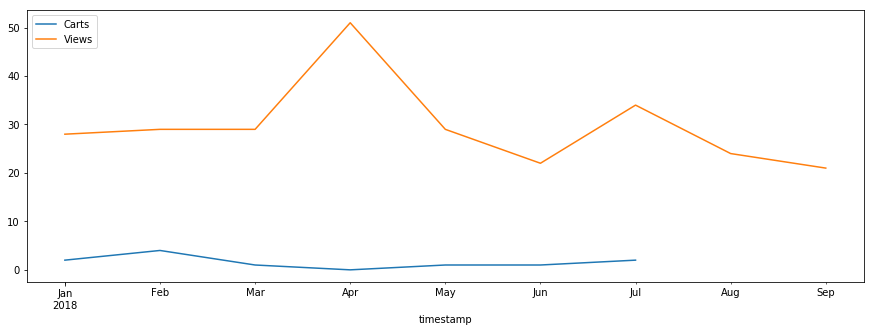

In [35]:
a = cart_flatten[cart_flatten['product_ids'] == 208].resample('M')['customer_id'].count()
b = views[views['product_id'] == 208].resample('M')['customer_id'].count()
a.plot(label='Carts')
b.plot(label='Views')
plt.legend(loc='upper left')

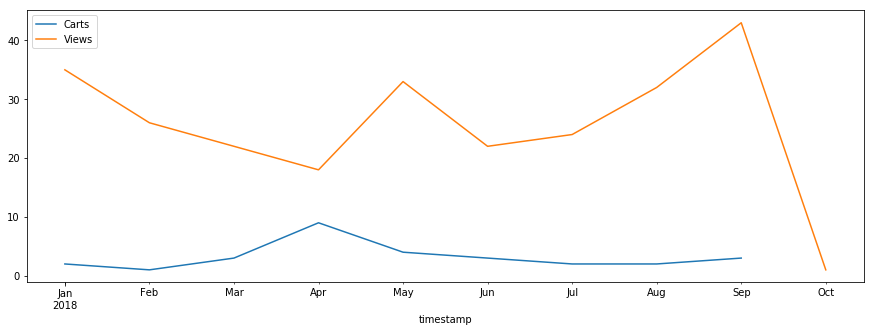

In [36]:
a = cart_flatten[cart_flatten['product_ids'] == 211].resample('M')['customer_id'].count()
b = views[views['product_id'] == 211].resample('M')['customer_id'].count()
a.plot(label='Carts')
b.plot(label='Views')
plt.legend(loc='upper left')

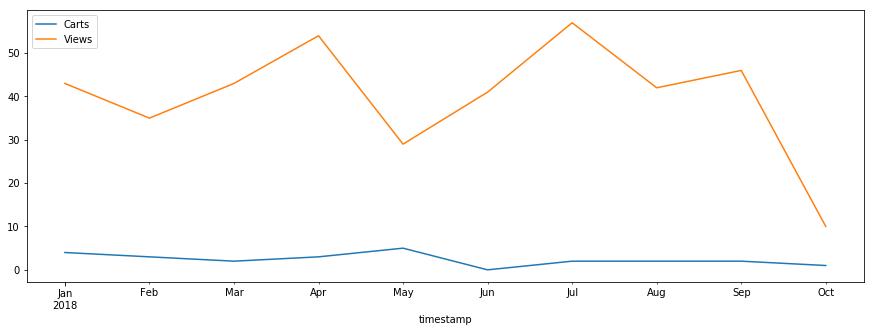

In [37]:
a = cart_flatten[cart_flatten['product_ids'] == 151].resample('M')['customer_id'].count()
b = views[views['product_id'] == 151].resample('M')['customer_id'].count()
a.plot(label='Carts')
b.plot(label='Views')
plt.legend(loc='upper left')

In [33]:
prodCorr['view'].nlargest(5)

2652  purchase    0.992065
3095  purchase    0.966236
2824  purchase    0.959301
1455  purchase    0.959153
1493  purchase    0.942135
Name: view, dtype: float64

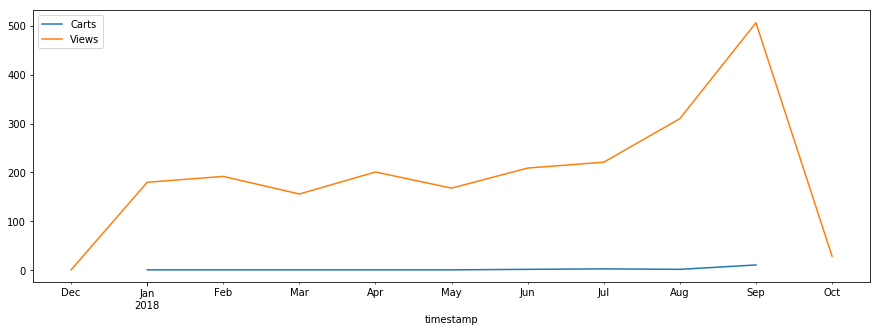

In [38]:
a = cart_flatten[cart_flatten['product_ids'] == 1493].resample('M')['customer_id'].count()
b = views[views['product_id'] == 1493].resample('M')['customer_id'].count()
a.plot(label='Carts')
b.plot(label='Views')
plt.legend(loc='upper left')

### Conclusion:
- There are more types of anomaly which needs to be addressed
 1. Products being added to cart repeatedly by the same person
 2. Customers visiting the products page repeatedly
- Gathering more products with frequent visits or purchase to increase the credibility of the results
- Analyzing the behavior of customers based on products or season 